<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Deep Learning From Scratch</h1>
<h2>Modular Network</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -i -n -v -m -g -iv

numpy      1.16.2
watermark  1.8.1
seaborn    0.9.0
matplotlib 3.1.0
pandas     0.24.2
Tue Sep 24 2019 2019-09-24T12:12:50-04:00

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 46e8ada9ae78bc5ab280631b85d64d9ea1891da7


# Load Dataset

In [3]:
X_train = np.load('input/X_train.npy')
X_test = np.load('input/X_test.npy')
y_train = np.load('input/y_train.npy')
y_test = np.load('input/y_test.npy')

Preprocessing

In [4]:
input_layer_size = X_train.shape[1]

X_train /= 255.
X_test /= 255.

## Initialize weights

We define the initializatino function as we'll have to call it more than once

In [5]:
def init_weights(L_in, L_out):
    epsilon = 0.12

    return 2*np.random.rand(L_out, L_in+1)*epsilon - epsilon

Set the layer sizes we'll be using

In [6]:
hidden_layer_size = 50
num_labels = 10

Initialize the weights. In this case we use a array of weight matrices so that we can easily add/remove layers

In [7]:
Thetas = []
Thetas.append(init_weights(input_layer_size, hidden_layer_size))
Thetas.append(init_weights(hidden_layer_size, num_labels))

## Utility functions

One-hot encoding to define the labels

In [8]:
def one_hot(K, pos):
    y0 = np.zeros(K)
    y0[pos] = 1

    return y0

Activation function base class. Here we must provide an interface to both the activation function and its derivative

In [9]:
class Activation(object):
    def f(z):
        pass

    def df(z):
        pass

The various activation functions simply extend the base class

In [10]:
class Linear(Activation):
    def f(z):
        return z

    def df(z):
        return np.ones(z.shape)

class ReLu(Activation):
    def f(z):
        return np.where(z > 0, z, 0)

    def df(z):
        return np.where(z > 0, 1, 0)

class Sigmoid(Activation):
    def f(z):
        return 1./(1+np.exp(-z))
    
    def df(z):
        h = Sigmoid.f(z)
        return h*(1-h)

class TanH(Activation):
    def f(z):
        return np.tanh(z)

    def df(z):
        return 1-np.power(np.tanh(z), 2.0)

## Forward Propagation and Prediction

The forward and predict functions are also generalized

In [11]:
def forward(Theta, X, active):
    N = X.shape[0]

    # Add the bias column
    X_ = np.concatenate((np.ones((N, 1)), X), 1)

    # Multiply by the weights
    z = np.dot(X_, Theta.T)

    # Apply the activation function
    a = active.f(z)

    return a

The predict function now takes the entire model as input and it must loop over the various layers

In [12]:
def predict(model, X):
    h = X.copy()

    for i in range(0, len(model), 2):
        theta = model[i]
        activation = model[i+1]

        h = forward(theta, h, activation)

    return np.argmax(h, 1)

The accuracy function is just the same as before

In [13]:
def accuracy(y_, y):
    return np.mean((y_ == y.flatten()))*100.

## Back propagation

In [14]:
def backprop(model, X, y):
    M = X.shape[0]

    Thetas=[0]
    Thetas.extend(model[0::2])
    activations = [0]
    activations.extend(model[1::2])

    layers = len(Thetas)

    K = Thetas[-1].shape[0]
    J = 0

    Deltas = [0]

    for i in range(1, layers):
        Deltas.append(np.zeros(Thetas[i].shape))

    deltas = [0]*(layers+1)

    for i in range(M):
        As = [0]
        Zs = [0, 0]
        Hs = [0, X[i]]

        # Forward propagation, saving intermediate results
        As.append(np.concatenate(([1], Hs[1])))  # Input layer

        for l in range(2, layers+1):
            Zs.append(np.dot(Thetas[l-1], As[l-1]))
            Hs.append(activations[l-1].f(Zs[l]))
            As.append(np.concatenate(([1], Hs[l])))

        y0 = one_hot(K, y[i])

        # Cross entropy
        J -= np.dot(y0.T, np.log(Hs[-1]))+np.dot((1-y0).T, np.log(1-Hs[-1]))

        deltas[layers] = Hs[layers]-y0

        # Calculate the weight deltas
        for l in range(layers-1, 1, -1):
            deltas[l] = np.dot(Thetas[l].T, deltas[l+1])[1:]*activations[l].df(Zs[l])

        Deltas[2] += np.outer(deltas[3], As[2])
        Deltas[1] += np.outer(deltas[2], As[1])

    J /= M

    grads = []

    grads.append(Deltas[1]/M)
    grads.append(Deltas[2]/M)

    return [J, grads]

## Model Definition

In [15]:
model = []

model.append(Thetas[0])
model.append(Sigmoid)
model.append(Thetas[1])
model.append(Sigmoid)

## Training procedure
The same basic idea as before

In [16]:
step = 0
tol = 1e-3
J_old = 1/tol
diff = 1

acc_train = []
acc_test = []
J_val = []
steps = []

while diff > tol:
    J_train, grads = backprop(model, X_train, y_train)

    diff = abs(J_old-J_train)
    J_old = J_train
    J_val.append(J_train)

    step += 1

    if step % 10 == 0:
        pred_train = predict(model, X_train)
        pred_test = predict(model, X_test)

        J_test, grads = backprop(model, X_test, y_test)

        acc_train.append(accuracy(pred_train, y_train))
        acc_test.append(accuracy(pred_test, y_test))
        steps.append(step)
        
        print(step, J_train, J_test, acc_train[-1], acc_test[-1])

    for i in range(len(Thetas)):
        Thetas[i] -= .5*grads[i]

10 3.1066703442137187 3.1223124514860214 45.7 41.9
20 2.8834967892918213 2.9154204030914235 56.54 53.800000000000004
30 2.578071124447666 2.6284440147620862 61.82 59.699999999999996
40 2.269848883241639 2.333836901261769 67.46 65.10000000000001
50 2.014031428818632 2.0853587364966195 72.96000000000001 69.89999999999999
60 1.8109391906187269 1.8858641244316585 76.96 74.6
70 1.6482135016149666 1.725073538391292 80.25999999999999 77.2
80 1.515881673882198 1.59414295763626 82.36 79.0
90 1.4066432185383093 1.4863417847503781 83.96000000000001 81.3
100 1.315071668693909 1.3964805099643078 85.26 82.69999999999999
110 1.2371598868338394 1.3205866155595278 85.98 83.8
120 1.1699802560746821 1.255663899828594 86.44 84.6
130 1.111397532044071 1.1994728785131956 87.3 85.6
140 1.059839876542069 1.150339523697407 87.83999999999999 86.4
150 1.014128324574433 1.107001757816776 88.08 87.2
160 0.9733559238540138 1.0684934264093129 88.38000000000001 87.4
170 0.9368052007542261 1.0340601181974034 88.660000

## Accuracy during training

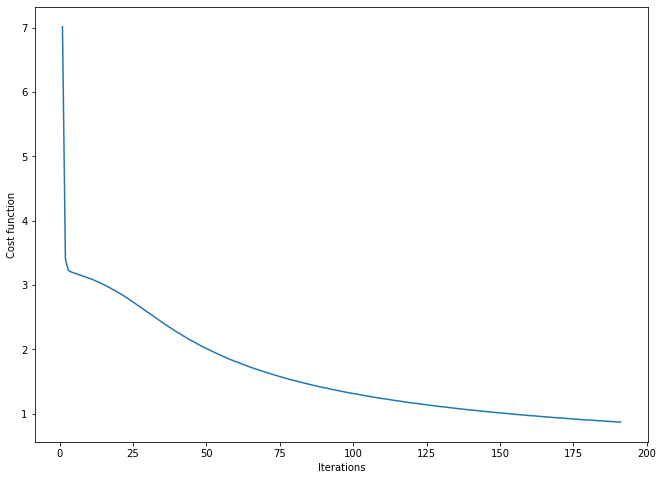

In [17]:
plt.plot(np.arange(1, len(J_val)+1), J_val)
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.gcf().set_size_inches(11, 8)

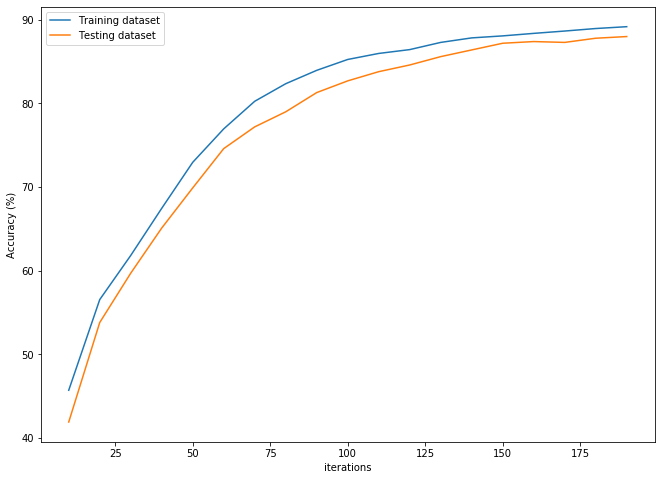

In [18]:
plt.plot(steps, acc_train, label='Training dataset')
plt.plot(steps, acc_test, label='Testing dataset')
plt.xlabel("iterations")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.gcf().set_size_inches(11, 8)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>